Include all the packages needed for this exercise as reported below

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import math 
import statsmodels.api as sm
import sklearn
from sklearn.neighbors import KernelDensity
from scipy.integrate import nquad
import uproot
import pandas

Welcome to JupyROOT 6.10/09


Define two classes where one defines the caracteristics of a sample (name, sample identification and cross-section), the other defines which setup to be fitted (center of the ellipse, radius or both) 

In [2]:
class Sample:
    def __init__(self, name, sample_id, xs):
        self.name = name
        #self.file = file
        self.sample_id = sample_id
        self.xs = xs
        
class FitSetup:
    x0y0 = 1
    ab = 2
    x0y0ab = x0y0 + ab

In the following parts open the files, called "anaTuples", where already a selection is applied (Central energy scale).

Specify for the two samples we want to analyze, Signal SM and TT, their cross-sections and their sample id (please refer to the exercise of significance estimation).

In [4]:
#path = "/gpfs/ddn/cms/user/cmsdas/2019/hh_bbtautau/eventTuples/"
#path = "/Users/Tita/Desktop/files_school/"
#path = "/Volumes/Silver/cms-das-2019/hh_bbtautau/eventTuples/"

path = "/gpfs/ddn/cms/user/cmsdas/2019/hh_bbtautau/anaTuples/"
#path = "/Users/Tita/Desktop/Run2_analysis_hh_bbtautau/anaTuples/"
#path = "./anaTuples/"

anaTuples = {'eTau': "eTau_tuple.root", 'muTau': "muTau_tuple.root", 'tauTau': "tauTau_tuple.root"} 
channel = "tauTau"

sample_list = [
    Sample("Signal", -125, 0.03353 * 2 * 5.809e-01 * 6.256e-02),
    Sample("TT", 1, 831.76)
]

with uproot.open(path+anaTuples[channel]) as file:
        tree = file[channel]
        df = tree.arrays('*', outputtype=pandas.DataFrame)    
        total_weight = np.sum(df.weight)

samples = {}
for sample in sample_list:
    samples[sample.name] = sample
    
    

Make the plot for both Signal and TT of mass of Higgs into bb candidate and of Higgs into tau pair candidate, in order to view the different behaviour of the signal and of the background. What can you notice?

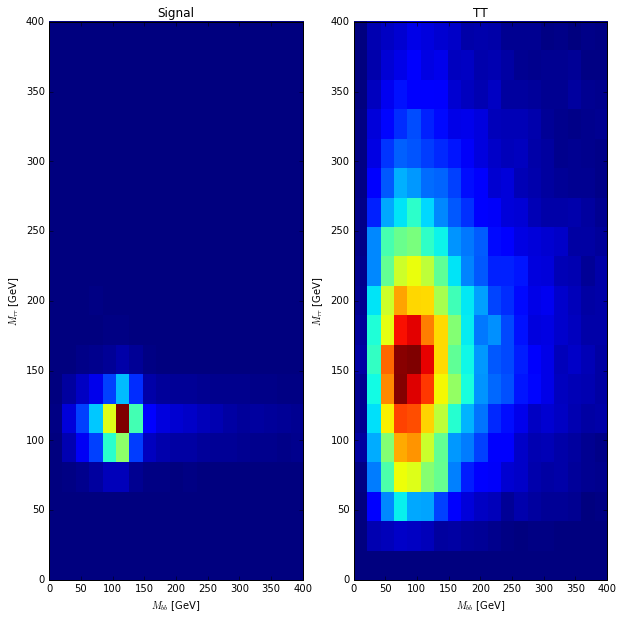

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

n = 0
bins_x = np.linspace(0, 400, 20)
bins_y = np.linspace(0, 400, 20)
for sample in sample_list:
    ax[n].hist2d(df[(df.sample_id == sample.sample_id)].m_bb, df[(df.sample_id == sample.sample_id)].m_sv, 
                 weights=df[(df.sample_id == sample.sample_id)].weight, bins=[bins_x, bins_y])
    ax[n].set_xlabel(r'$M_{bb}$ [GeV]')
    ax[n].set_ylabel(r'$M_{\tau\tau}$ [GeV]')
    ax[n].set_title(sample.name)
    
    n += 1
#plt.subplots_adjust(bottom=0.1, right=1.5, top=1.5)
plt.show()

Look at the code for the minimization of the ellipse cut around mbb and mtautau. Here it is first calculated how to do it with 2 paramenters (the center of the ellipse or the radius of the ellipse), then also there is the possiblity to have a fit of 4 parameters

In [11]:
class EllipseMinimization( ROOT.TPyMultiGenFunction ):
    def __init__( self, samples, x0, y0, a, b, fit_setup):
        self.samples = samples
        self.x0 = x0
        self.y0 = y0
        self.a = a
        self.b = b
        self.fit_setup = fit_setup
        ROOT.TPyMultiGenFunction.__init__( self, self )

    def NDim(self):
        if self.fit_setup == FitSetup.x0y0ab:
            return 4
        return 2

    def DoEval(self, args):
        n = 0
        x0 = self.x0
        y0 = self.y0
        a = self.a
        b = self.b

        if self.fit_setup & FitSetup.x0y0 != 0:
            x0 = args[0]
            y0 = args[1]
            n = 2
        if self.fit_setup & FitSetup.ab != 0:
            a = args[n]
            b = args[n+1]
        
        n_signal = self.CalcNumEvents('Signal', x0, y0, a, b)
        n_bkg = self.CalcNumEvents('TT', x0, y0, a, b)
        print(n_signal,n_bkg)
        
        #target = -n_signal / math.sqrt(n_bkg) # better formula
        #Discovery sensitivity for a counting experiment with background uncertainty
        #target = math.sqrt(2*((n_signal+n_bkg)*math.log(1 + (n_signal/n_bkg)) - n_signal))
        target = -n_signal/math.sqrt(n_signal+n_bkg)
        #print("target = ", target)
        return target
        
    def CalcNumEvents(self, sample_name, x0, y0, a, b):
        sample = self.samples[sample_name]
        x = df.m_bb
        y = df.m_sv
        weight = df.weight
        inside_ellipse = ((x - x0) / a)**2 + ((y - y0) / b) ** 2 < 1
        n_inside = np.sum(inside_ellipse * weight)
        return n_inside / total_weight * sample.xs

In [12]:
def FindParams(samples, x0, y0, a, b, fit_setup):
    minimizer = ROOT.Math.Factory.CreateMinimizer("Minuit", "Combined")
    minimizer.SetTolerance(0.05)
    minimizer.SetPrintLevel(2)
    minimizer.SetStrategy(2)
    ellipse = EllipseMinimization(samples, x0, y0, a, b, fit_setup)

    minimizer.SetFunction(ellipse)

    # Set the variables to be minimized!
    c_factor = 0.1
    r_factor = 5.0
    n = 0
    if fit_setup & FitSetup.x0y0 != 0:
        minimizer.SetLimitedVariable(0, "x0", x0, 1, x0 * (1 - c_factor), x0 * (1 + c_factor))
        minimizer.SetLimitedVariable(1, "y0", y0, 1, y0 * (1 - c_factor), y0 * (1 + c_factor))
        n = 2
    if fit_setup & FitSetup.ab != 0:
        minimizer.SetLimitedVariable(n, "a", a, 0.1, max(2, a * (1 - r_factor)), a * (1 + r_factor))
        minimizer.SetLimitedVariable(n + 1, "b", b, 0.1, max(2, b * (1 - r_factor)), b * (1 + r_factor))
        
    minimizer.Minimize()
    #result = [x for ix in minimizer.X()]
    result = [minimizer.X()[i] for i in range(ellipse.NDim())]
    return tuple(result)

Now you have to choose a starting point for the minimization. Here following it is for the center values, taking the indices of the maximum values for the mass candidate and their bin extremis.

In [13]:
sgn_id = samples["Signal"].sample_id
hist, bin_edges = np.histogram(df[(df.sample_id == sgn_id)].m_bb, bins=200, range=(0, 200))
max_bin = np.argmax(hist)
x0 = (bin_edges[max_bin] + bin_edges[max_bin + 1]) / 2
hist, bin_edges = np.histogram(df[(df.sample_id == sgn_id)].m_sv, bins=200, range=(0, 200))
max_bin = np.argmax(hist)
y0 = (bin_edges[max_bin] + bin_edges[max_bin + 1]) / 2
print(x0, y0)

(115.5, 114.5)


Here following it is for the radius values using the percentiles.

In [14]:
interval = np.percentile(df[(df.sample_id == sgn_id)].m_bb, [25, 75])
a = max(x0 - interval[0], interval[1] - x0)
interval = np.percentile(df[(df.sample_id == sgn_id)].m_sv, [25, 75])
b = max(y0 - interval[0], interval[1] - y0)
print(a, b)

(23.739181518554688, 12.567741394042969)


Calculate new center parameters starting from the calculated one

In [15]:
new_x0, new_y0 = FindParams(samples, x0, y0, a, b, FitSetup.x0y0)
print(new_x0, new_y0)

(0.00015244934718798865, 52.030971428036054)
(0.00015244934718798865, 52.030971428036054)
(0.0001522588063687352, 51.96593983488514)
(0.00015256028376352872, 52.068834087986524)
(0.000145100606752688, 49.52284587240686)
(0.00015428967233843558, 52.659074513339036)
(0.00015240291859415083, 52.01512534614736)
(0.00015264646081329368, 52.098246320290436)
(0.0001420608465023138, 48.48537551485744)
(0.00015181527750839283, 51.8145634079889)
(0.00015151014815228424, 51.71042274026952)
(0.00015379153588163908, 52.48906051046579)
(0.00015227924556181552, 51.97291573272132)
(0.00015279416665619323, 52.14865833341754)
(0.0001523308308295369, 51.99052178771878)
(0.0001524682692204012, 52.03742951884444)
(0.0001519123757770647, 51.847703052967155)
(0.00015331107677893257, 52.325079789614065)
(0.00015234988519194977, 51.99702504276428)
(0.00015286479675225877, 52.17276438948228)
(0.00013601893667113232, 46.42327132355958)
(0.00015599484678072346, 53.2410506537622)
(0.00015651976627605057, 53.420205

Calculate new radius parameters starting from the starting point for radius and the calculated one for centers

In [16]:
new_a, new_b = FindParams(samples, new_x0, new_y0, a, b, FitSetup.ab)
print(new_a, new_b)

(0.00015651976627605057, 53.42020570930799)
(0.00015651976627605057, 53.42020570930799)
(0.00015656049689680252, 53.4341070726374)
(0.00015646464271430285, 53.401392034345065)
(0.0001613452594175369, 55.067146810743175)
(0.0001512543952345189, 51.62313425394707)
(0.0002713746588560338, 92.62018750280238)
(3.8564058761343283e-05, 13.161915590797939)
(0.00015662259704801455, 53.45530185800703)
(0.0001564134276189292, 53.3839123191923)
(0.00016683298419710002, 56.94010761036063)
(0.00014526614276522986, 49.57934332351274)
(0.00028524461194489974, 97.35400333203698)
(4.553877417692828e-05, 15.542386384546138)
(0.0001809301156018311, 61.751459412558596)
(0.0001294393452408026, 44.17765636990887)
(0.00018383140578412011, 62.741669927484395)
(0.00012862558233498063, 43.89991904086798)
(0.00016147814813857695, 55.11250173928227)
(0.00015067292329570077, 51.42467784601281)
(0.0005099718190840894, 174.0534127387752)
(0.0010718985762412975, 365.8390489884478)
(0.00013199930437187804, 45.051370576

Calculate the final parameters fitting the 4 paramteres starting from the center and radius values obtained by previus fit

In [17]:
final_x0, final_y0, final_a, final_b = FindParams(samples, new_x0, new_y0, new_a, new_b, FitSetup.x0y0ab)
print(new_x0, new_y0, new_a, new_b)
print(final_x0, final_y0, final_a, final_b)

(0.0013861336755835163, 473.08750742493805)
(0.0013861336755835163, 473.08750742493805)
(0.0013861399390311458, 473.0896451399933)
(0.0013861463161327124, 473.0918216451442)
(0.0013845924670967574, 472.56149287506713)
(0.0013862313491915961, 473.1208434332911)
(0.0013868143919035243, 473.3198359461829)
(0.001385542639020544, 472.8857866102007)
(0.0014161895157897527, 483.34556750759555)
(0.001351617545185013, 461.3071500295317)
(0.0013861555935570286, 473.09498803062525)
(0.00138611793874864, 473.08213644224173)
(0.0013881294850839403, 473.7686773283048)
(0.0013843376605524123, 472.47452738605034)
(0.001499314944821249, 511.71628147036284)
(0.0008323516784645283, 284.08167826958027)
(0.0015269182450266521, 521.137289502203)
(0.0004539049263778589, 154.91777886256477)
(0.0013863207423440696, 473.1513533216442)
(0.0013860057527798689, 473.0438473643058)
(0.0013977166235840763, 477.04076827902617)
(0.0013745560476269953, 469.1360623022026)
(0.0019054337956943674, 650.324669869096)
(0.0004